In [1]:
import numpy as np
import camb
import matplotlib.pyplot as plt

In [7]:
def get_eq(om0h2, theta):
    z_eq = 2.5*1e4 * om0h2 / theta**4
    k_eq = 7.46*1e-2 * om0h2 / theta**2  # in Mpc^-1
    return z_eq, k_eq
def get_zdrag(om0h2, ombh2):
    b1 = 0.313*(om0h2)**-0.419*(1+0.607*om0h2**0.674)
    b2 = 0.238*(om0h2)**0.223
    zdrag = 1291*om0h2**0.251/(1+0.659*om0h2**0.828)*(1+b1*ombh2**b2)
    return zdrag
def get_s(om0h2, ombh2, theta):
    zdrag = get_zdrag(om0h2, ombh2)
    z_eq, k_eq = get_eq(om0h2, theta)
    Req = 31.5*ombh2*(theta)**-4 * (z_eq/1e3)**-1
    Rdrag = 31.5*ombh2*(theta)**-4 * (zdrag/1e3)**-1
    s = (
    (2./(3*k_eq))*np.sqrt(6./Req)*
    np.log((np.sqrt(1+Rdrag) + np.sqrt(Rdrag + Req))/(1+np.sqrt(Req)))
    )
    return s

In [11]:
theta = 2.728/2.7
keq = get_eq(0.4, theta)[1]
s = get_s(0.4, 0.16, theta)
print(keq*s/np.pi)

0.7091165055602682


In [63]:
class EisensteinHu:
    def __init__(self, ombh2=0.022, omch2=0.122,h=0.675, mnu=0.06, ns=0.965, As=2e-9, tau=0.06, TCMB=2.728):
        self.name = "Eisenstein-Hu"
        self.params = {
            'ombh2': ombh2,
            'omch2': omch2,
            'h': h,
            'mnu': mnu,
            'ns': ns,
            'As': As,
            'tau': tau,
            'TCMB': TCMB
        }
        self.ombh2 = self.params['ombh2']
        self.omch2 = self.params['omch2']
        self.om0h2 = ombh2 + omch2
        self.f_baryon = ombh2/self.om0h2
        self.theta = TCMB/2.7
        self.zeq = 2.5*1e4 * self.om0h2 * (self.theta)**-4
        self.keq = 7.46*1e-2 * self.om0h2*(self.theta)**-2 # in Mpc^-1

        # k_silk calculation
        self.ksilk = 1.6 * self.ombh2**0.52 * self.om0h2**0.73 * ( 1+ (10.4*self.om0h2) ** -0.95 ) # in Mpc^-1

    # calculate zdrag [4]

        self.z_drag_b1 = 0.313 * self.om0h2 ** -0.419 * (1 + 0.607 * self.om0h2 ** 0.674)
        self.z_drag_b2 = 0.238 * self.om0h2 ** 0.223
        self.ombh2 = self.params['ombh2']
        self.zdrag    = 1291 * self.om0h2 ** 0.251 / (1. + 0.659 * self.om0h2 ** 0.828) * \
                           (1. + self.z_drag_b1 * self.ombh2 ** self.z_drag_b2) # [4]

    # calculate s (sound horizon)    [6]
        self.Req = 31.5*self.ombh2*(self.theta)**-4 * (1e3/self.zeq)
        self.Rdrag = 31.5*self.ombh2*(self.theta)**-4 * (1e3/self.zdrag)
        self.s = 2. / (3.*self.keq) * np.sqrt(6. / self.Req) * \
                    np.log((np.sqrt(1 + self.Rdrag) + np.sqrt(self.Rdrag + self.Req)) / (1 + np.sqrt(self.Req)) )
    # Calculate alpha_c, beta_c [11],[12]
        a1 = (46.9*self.om0h2)**0.670*(1+(32.1*self.om0h2)**-0.532)
        a2 = (12.0*self.om0h2)**0.424*(1+(45.0*self.om0h2)**-0.582)
        self.alpha_c = a1**(-self.f_baryon)*a2**(-self.f_baryon**3) # [11]
        
        b1 = 0.944 / (1 + (458*self.om0h2) ** -0.708)
        b2 =  0.395 * self.om0h2 ** -0.0266
        self.beta_c = 1. / ( 1 + b1 * ((1-self.f_baryon) ** b2 - 1) ) # [12]

    # Calculate alpha_b [14]
        def G(y): # [15]
                return y * ( (-6. * np.sqrt(1 + y)) + ( (2 + 3 * y) * np.log( (np.sqrt(1+y) + 1) / (np.sqrt(1+y)-1) ) ) )
        self.alpha_b = 2.07*self.keq*self.s*(1+self.Rdrag)**-(3/4)*G((1+self.zeq)/(1+self.zdrag)) # [14]    
        self.beta_node = 8.41*self.om0h2**0.435 # [23]
        self.beta_b = 0.5 + self.f_baryon + ( 3 - 2*self.f_baryon )*np.sqrt( (17.2*self.om0h2)**2 + 1) # [24]
    def Transfer_function_no_baryon(self,k):
        q = k/(13.41*self.keq) # [10]
        ks = k*self.s
        T_c = self.alpha_c * np.log(18*self.beta_c*q) / (14.2*q**2) # [9]
        T_b = self.alpha_b * np.sin(ks)/ks
        return (1-self.f_baryon)*T_c + self.f_baryon*T_b

    def Transfer_function(self, k):
        # Calculate T_c
        q = k/(13.41*self.keq) # [10]
        ks = k*self.s
        def C(alpha_c, q):  # [20]
            return 14.2/alpha_c + 386./(1+69.9*q**1.08)
        def Tilde0(q, alpha_c, beta_c): #  [19]
            return np.log(np.e+1.8*beta_c*q)/(np.log(np.e+1.8*beta_c*q)+C(alpha_c, q)*q**2)

        f = 1/(1+(ks/5.4)**4) # [18]
        T_c = f*Tilde0(q, 1, self.beta_c) + (1-f)*Tilde0(q, self.alpha_c, self.beta_c) # [17]

        # Calculate T_b
        self.stildek = self.s/((1+ (self.beta_node/ks)**3 )**(1/3)) # [22]
        def j0(x):
            return np.sin(x)/x
        T_b = ( Tilde0(q,1,1)/(1+(ks/5.2)**2) + self.alpha_b/(1+(self.beta_b/ks)**3) * np.exp(-(k/self.ksilk)**1.4) )  * j0(k*self.stildek) # [19]
        # Total Transfer function
        T_k = self.f_baryon*T_b + (1-self.f_baryon)*T_c # [16]
        return T_k


    

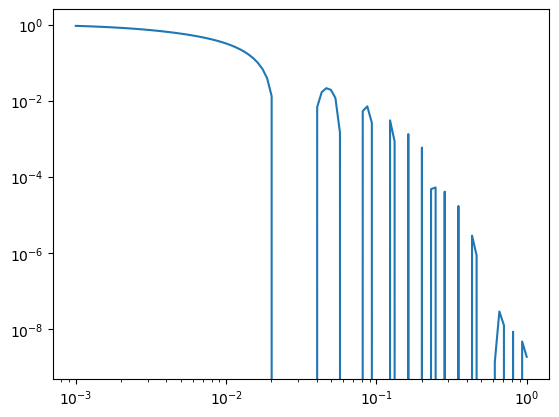

In [65]:
om0h2 = 0.2*0.5**2
ombh2 = om0h2*1
pars = EisensteinHu(ombh2=ombh2, omch2=om0h2-ombh2, h=0.5)
karr = np.logspace(-3,0,100)
p= pars.Transfer_function(karr)
plt.plot(karr, p)
plt.xscale('log')
plt.yscale('log')
plt.show()


In [54]:
print(pars.alpha_c*(om0h2-ombh2)/om0h2)
print(pars.alpha_b*ombh2/om0h2)
print(om0h2, pars.f_baryon)

0.5536167979002934
0.09441023832083474
0.2 0.20000000000000004
